# Experiment Template


**In this notebook:**

* Load original mri data + aneurysm mask
* Resample Images to 1.5 mm Voxelsize
* Filter images based on size
* Train network to predict vessel mask
* Evaluate aneurysm mask

**Todo:**
* Check percentage of 1s in resampled mask
* Write evaluation
* Try out different batch_sizes

## Dependencies
Install, load, and initialize all required dependencies for this experiment.

### Install Dependencies

In [2]:
#It should be possible to run the notebook independent of anything else. 
# If dependency cannot be installed via pip, either:
# - download & install it via %%bash
# - atleast mention those dependecies in this section

import sys
!{sys.executable} -m pip install -q -e ../../utils/


  ERROR: HTTP error 403 while getting https://pytorch-geometric.com/whl/torch-1.8.1+cu111.html
ERROR: Could not install requirement torch-scatter@ https://pytorch-geometric.com/whl/torch-1.8.1+cu111.html from https://pytorch-geometric.com/whl/torch-1.8.1+cu111.html (from aneurysm-detection-utils==0.0.0) because of HTTP error 403 Client Error: Forbidden for url: https://pytorch-geometric.com/whl/torch-1.8.1+cu111.html for URL https://pytorch-geometric.com/whl/torch-1.8.1+cu111.html
You should consider upgrading via the '/group/cake/leo/.venv/bin/python -m pip install --upgrade pip' command.


### Import Dependencies

# System libraries

In [2]:
from __future__ import absolute_import, division, print_function
import logging, os, sys

# Enable logging
logging.basicConfig(format='[%(levelname)s] %(message)s', level=logging.INFO, stream=sys.stdout)

# Re-import packages if they change
%load_ext autoreload
%autoreload 2

# Recursion Depth
import sys
sys.setrecursionlimit(10000)

# Intialize tqdm to always use the notebook progress bar
import tqdm
tqdm.tqdm = tqdm.tqdm_notebook

# Third-party libraries
import comet_ml
import numpy as np
import pandas as pd
import nilearn.plotting as nip
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import collections
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)
%config InlineBackend.figure_format='retina'  # adapt plots for retina displays
import git


# Project utils
import aneurysm_utils
from aneurysm_utils import evaluation, training


/opt/conda/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


### Initialize Environment

In [3]:
env = aneurysm_utils.Environment(project="ML_in_MIP", root_folder="/workspace/")
env.cached_data["comet_key"] = "EGrR4luSis87yhHbs2rEaqAWs" 
env.print_info()

Environment Info:

Library Version: 0.1.0
Configured Project: ML_in_MIP

Folder Structure: 
- Root folder: /workspace
 - Project folder: /workspace/ML_in_MIP
 - Datasets folder: /workspace/ML_in_MIP/datasets
 - Models folder: /workspace/ML_in_MIP/models
 - Experiments folder: /workspace/ML_in_MIP/experiments


## Load Data
Download, explore, and prepare all required data for the experiment in this section.

In [4]:
dataset_params = {
    "prediction": "mask",
    "mri_data_selection": "unprocessed", 
    "balance_data": False,
    "seed": 1
}

preprocessing_params = {
    'min_max_normalize': True,
    'mean_std_normalize': False,
    'smooth_img': False, # can contain a number: smoothing factor
}


### Load Meta Data

In [5]:
from aneurysm_utils.data_collection import load_aneurysm_dataset

df = load_aneurysm_dataset(
    env,
    mri_data_selection=dataset_params["mri_data_selection"],
    random_state=dataset_params["seed"]
)
df.head()

,Aneurysm Geometry,Angiography Data,Vessel Geometry,Labeled Mask Index,Location,Age,Sex,Rupture Status,Age Bin,Aneurysm Count,Case,Path Orig,Path Mask,Path Vessel,Path Labeled Mask
0,A001.stl,A001_orig.nii.gz,A001_vessel.stl,1,Acom,48,m,1.0,"(40, 50]",1,A001,/workspace/ML_in_MIP/datasets/unprocessed/A001...,/workspace/ML_in_MIP/datasets/unprocessed/A001...,/workspace/ML_in_MIP/datasets/unprocessed/A001...,/workspace/ML_in_MIP/datasets/unprocessed/A001...
1,A003.stl,A003_orig.nii.gz,A003_vessel.stl,1,Pcom,58,f,0.0,"(50, 60]",1,A003,/workspace/ML_in_MIP/datasets/unprocessed/A003...,/workspace/ML_in_MIP/datasets/unprocessed/A003...,/workspace/ML_in_MIP/datasets/unprocessed/A003...,/workspace/ML_in_MIP/datasets/unprocessed/A003...
2,A005.stl,A005_orig.nii.gz,A005_vessel.stl,1,PICA,45,m,1.0,"(40, 50]",1,A005,/workspace/ML_in_MIP/datasets/unprocessed/A005...,/workspace/ML_in_MIP/datasets/unprocessed/A005...,/workspace/ML_in_MIP/datasets/unprocessed/A005...,/workspace/ML_in_MIP/datasets/unprocessed/A005...
3,A006.stl,A006_orig.nii.gz,A006_vessel.stl,1,ACom,46,f,1.0,"(40, 50]",1,A006,/workspace/ML_in_MIP/datasets/unprocessed/A006...,/workspace/ML_in_MIP/datasets/unprocessed/A006...,/workspace/ML_in_MIP/datasets/unprocessed/A006...,/workspace/ML_in_MIP/datasets/unprocessed/A006...
4,A008.stl,A008_orig.nii.gz,A008_vessel.stl,1,ACA,72,f,0.0,"(70, 80]",1,A008,/workspace/ML_in_MIP/datasets/unprocessed/A008...,/workspace/ML_in_MIP/datasets/unprocessed/A008...,/workspace/ML_in_MIP/datasets/unprocessed/A008...,/workspace/ML_in_MIP/datasets/unprocessed/A008...


### Load & Split MRI Data

In [6]:
# Load MRI images and split into train, test, and validation
from aneurysm_utils.data_collection import split_mri_images
#case_list = ["A001", "A130_R", "A005"]
#df = df.loc[df["Case"].isin(case_list)]

train_data, test_data, val_data, _ = split_mri_images(
    env, 
    df, 
    prediction=dataset_params["prediction"], 
    encode_labels=False,
    random_state=dataset_params["seed"],
    balance_data=dataset_params["balance_data"]
)

mri_imgs_train, labels_train = train_data
mri_imgs_test, labels_test = test_data
mri_imgs_val, labels_val = val_data

         Images
-----  --------
All         109
Train        87
Val          11
Test         11



  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [7]:
from aneurysm_utils import preprocessing

preprocessing.check_mri_shapes(mri_imgs_train)

Most common:
(93, 93, 80):      80
(47, 47, 40):       3
(72, 72, 65):       2
(47, 47, 41):       2


## Transform & Preprocess Data

In [8]:
from aneurysm_utils import preprocessing

size_of_train = len(mri_imgs_train)
size_of_test = len(mri_imgs_test)
size_of_val = len(mri_imgs_val)

# preprocess all lists as one to have a working mean_std_normalization
mri_imgs = mri_imgs_train + mri_imgs_test + mri_imgs_val
mri_imgs = preprocessing.preprocess(env, mri_imgs, preprocessing_params)

mri_imgs_train = mri_imgs[:size_of_train]
mri_imgs_train = [train for train in mri_imgs_train]
mri_imgs_test = mri_imgs[size_of_train : size_of_train + size_of_test]
mri_imgs_test = [test for test in mri_imgs_test]
mri_imgs_val = mri_imgs[size_of_train + size_of_test :]
mri_imgs_val = [val for val in mri_imgs_val]

# preprocess mask
x, y, h = labels_train[0].shape
labels_train = [label_train for label_train in labels_train]
labels_test = [label_test for label_test in labels_test]
labels_val = [label_val for label_val in labels_val]
# flatten

[INFO] Preprocessing: Min Max Normalize...


In [9]:
train_index = [i for i, e in enumerate(mri_imgs_train) if e.shape != (93, 93, 80)]
mri_imgs_train = [i for j, i in enumerate(mri_imgs_train) if j not in train_index]
labels_train = [i for j, i in enumerate(labels_train) if j not in train_index]

test_index = [i for i, e in enumerate(mri_imgs_test) if e.shape != (93, 93, 80)]
mri_imgs_test = [i for j, i in enumerate(mri_imgs_test) if j not in test_index]
labels_test = [i for j, i in enumerate(labels_test) if j not in test_index]

val_index = [i for i, e in enumerate(mri_imgs_val) if e.shape != (93, 93, 80)]
mri_imgs_val = [i for j, i in enumerate(mri_imgs_val) if j not in val_index]
labels_val = [i for j, i in enumerate(labels_val) if j not in val_index]

mri_imgs_train[0].shape
preprocessing.check_mri_shapes(mri_imgs_train)
print(np.unique(labels_val[0], return_counts=True))

Most common:
(93, 93, 80):      80
(array([0., 1.], dtype=float32), array([691892,     28]))


### Optional: View image


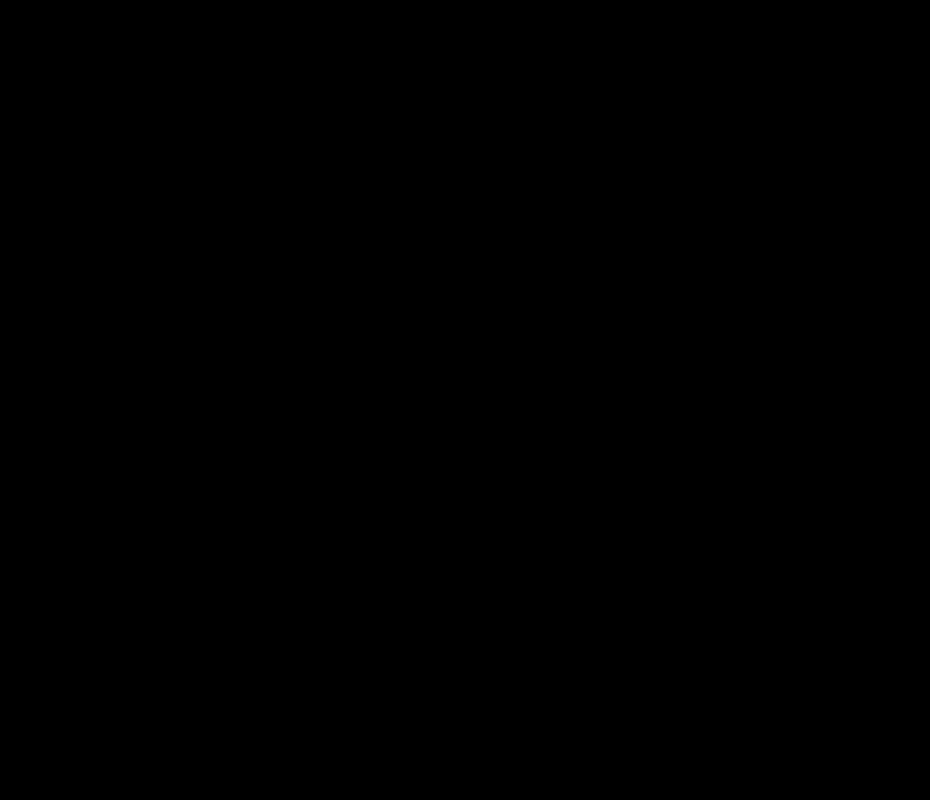
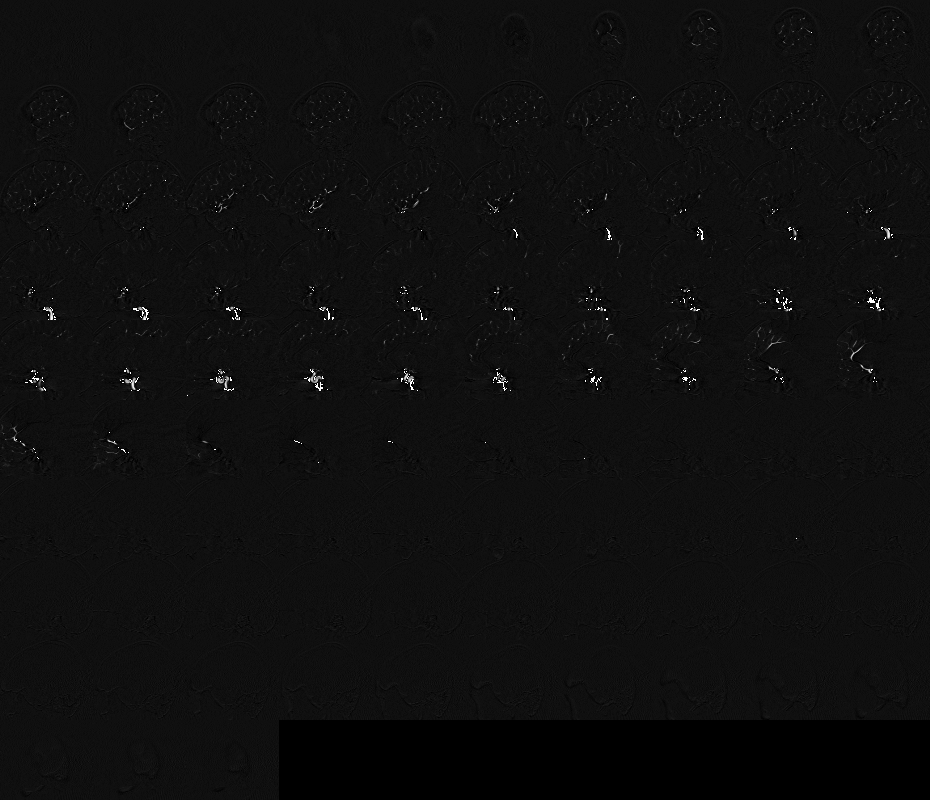

In [10]:
idx = 0
nip.view_img(
    nib.Nifti1Image(mri_imgs_train[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

In [11]:
evaluation.plot_slices(mri_imgs_train[0])

0.0 1.0 None None


## Train Model
Implementation, configuration, and evaluation of the experiment.

### Train Deep Model 3D data

In [12]:
artifacts = {
    "train_data": (mri_imgs_train, labels_train),
    "val_data": (mri_imgs_val, labels_val),
    "test_data": (mri_imgs_test, labels_test)
}

# Define parameter configuration for experiment run
params = {
    "batch_size": 3,
    "epochs": 100,
    "learning_rate": 5.0e-3, # 3e-04, 1.0E-5
    "es_patience": None, # None = deactivate early stopping
    "weight_decay": 0.001, # 1e-3
    "model_name": 'SimpleCNN3D',
    "optimizer_momentum": 0.9,
    "optimizer":'Adam',
    "criterion": "CrossEntropyLoss", 
    "criterion_weights": [1.0, 1000.0], # [1.75, 1.0],
    "sampler": None,   #'ImbalancedDatasetSampler2',
    "shuffle_train_set": True,
    "scheduler": "ReduceLROnPlateau", # "ReduceLROnPlateau",
    "save_models": False,
    "debug": False,
}

params.update(dataset_params)
params.update(preprocessing_params)

# data augmentation

In [13]:
# Run experiment and sync all metadata
exp = env.create_experiment(
    params["prediction"] + "-pytorch-" + params["model_name"],
    comet_ml.Experiment(
        env.cached_data["comet_key"],
        project_name=env.project + "-" + params["prediction"],
        disabled=params["debug"],
    ),
)
exp.run(training.train_pytorch_model, params, artifacts)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/ml-in-mip-mask/bcae471e917d410dbb17f2d6ca6b4894



[INFO] Experiment mask-pytorch-SimpleCNN3D is initialized.
[INFO] Running experiment: 2021-05-31-11-53-10_mask-pytorch-simplecnn3d
Number of Classes 2
Selected model: SimpleCNN3D


COMET ERROR: File could not be uploaded


[INFO] Train dataset loaded. Length: 80
[INFO] Validation dataset loaded. Length: 11
[INFO] Engine run starting with max_epochs=100.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:25
[INFO] Learning rate: 0.005
[INFO] Engine run complete. Time taken: 00:00:25
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.60
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:04
[INFO] Learning rate: 0.005
[INFO] Engine run complete. Time taken: 00:00:04
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.59
[INFO] Epoch[1] Complete. Time taken: 00:00:43
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:47
[INFO] Learning rate: 0.005
[INFO] Engine run complete. Time taken: 00:00:47
[INFO] Training Results - Epoch: 2 Bal Avg accuracy: 0.51 Avg loss: 0.55
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy (): 0.9973807183874822
Balanced Accuracy (): 0.9566774423038796


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rbendias/ml-in-mip-mask/bcae471e917d410dbb17f2d6ca6b4894
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [271]              : (0.03729980066418648, 0.8595324754714966)
COMET INFO:     test_accuracy           : 0.9973807183874822
COMET INFO:     test_bal_acc            : 0.9566774423038796
COMET INFO:     test_f1                 : 0.06264007815642779
COMET INFO:     test_precision          : 0.032428894442461026
COMET INFO:     test_recall             : 0.9159663865546218
COMET INFO:     test_sen                : 0.9159663865546218
COMET INFO:     test_spec               : 0.9973884980531375
COMET INFO:     train_accuracy [100]    : (0.9976224491270668, 0.999782380911088)
COMET INFO:     train_avg_loss [100]    : (0.08060209155082702

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   6226685
         1.0       0.03      0.92      0.06       595

    accuracy                           1.00   6227280
   macro avg       0.52      0.96      0.53   6227280
weighted avg       1.00      1.00      1.00   6227280



COMET INFO:     train_sen [100]         : (0.00025033377837116157, 0.8104138851802403)
COMET INFO:     train_spec [100]        : (0.9976629883738849, 0.9999988254770154)
COMET INFO:     validate_accuracy [100] : (0.9982943377584377, 0.9998358980018709)
COMET INFO:     validate_bal_acc [100]  : (0.5008028186267962, 0.9646145272956014)
COMET INFO:     validate_sen [100]      : (0.001606425702811245, 0.9309236947791165)
COMET INFO:     validate_spec [100]     : (0.9983053598120862, 0.9999992115507811)
COMET INFO:   Others:
COMET INFO:     Name : 2021-05-31-11-53-10_mask-pytorch-simplecnn3d
COMET INFO:   Parameters:
COMET INFO:     balance_data       : 1
COMET INFO:     batch_size         : 3
COMET INFO:     criterion          : CrossEntropyLoss
COMET INFO:     criterion_weights  : [1.0, 1000.0]
COMET INFO:     debug              : 1
COMET INFO:     dropout            : 1
COMET INFO:     dropout2           : 1
COMET INFO:     epochs             : 100
COMET INFO:     es_patience        : 1


[INFO] Experiment run completed: mask-pytorch-SimpleCNN3D. Duration: 1 hours 38 minutes 38 seconds


## Evaluate Model

Do evaluation, e.g. visualizations  

In [14]:
from aneurysm_utils.utils.pytorch_utils import predict

In [15]:
model = exp.artifacts["model"]

In [16]:
predictions = predict(model, mri_imgs_val,apply_softmax=False )

In [20]:
predictions[0][1]

array([[[2.6956425, 2.5230427, 2.5297809, ..., 2.5164292, 2.5239413,
         2.7135153],
        [2.494128 , 2.242309 , 2.2423267, ..., 2.2231643, 2.2296388,
         2.5174057],
        [2.4889317, 2.2341   , 2.2377336, ..., 2.2210717, 2.219593 ,
         2.5121012],
        ...,
        [2.464195 , 2.2000973, 2.2085664, ..., 2.2353754, 2.23292  ,
         2.5163288],
        [2.4662642, 2.2060084, 2.1947322, ..., 2.2213666, 2.2289543,
         2.5144582],
        [2.6772013, 2.486663 , 2.4655454, ..., 2.4896693, 2.4953682,
         2.7005544]],

       [[2.504393 , 2.2565825, 2.2576828, ..., 2.250914 , 2.2586796,
         2.5332484],
        [2.2096472, 1.8437998, 1.8432616, ..., 1.832525 , 1.8395432,
         2.2532864],
        [2.209936 , 1.836369 , 1.837262 , ..., 1.831311 , 1.8285838,
         2.2414927],
        ...,
        [2.1885605, 1.8142493, 1.8110644, ..., 1.8427839, 1.8476356,
         2.2523446],
        [2.1880183, 1.8108612, 1.8027688, ..., 1.8325309, 1.839912 ,
   


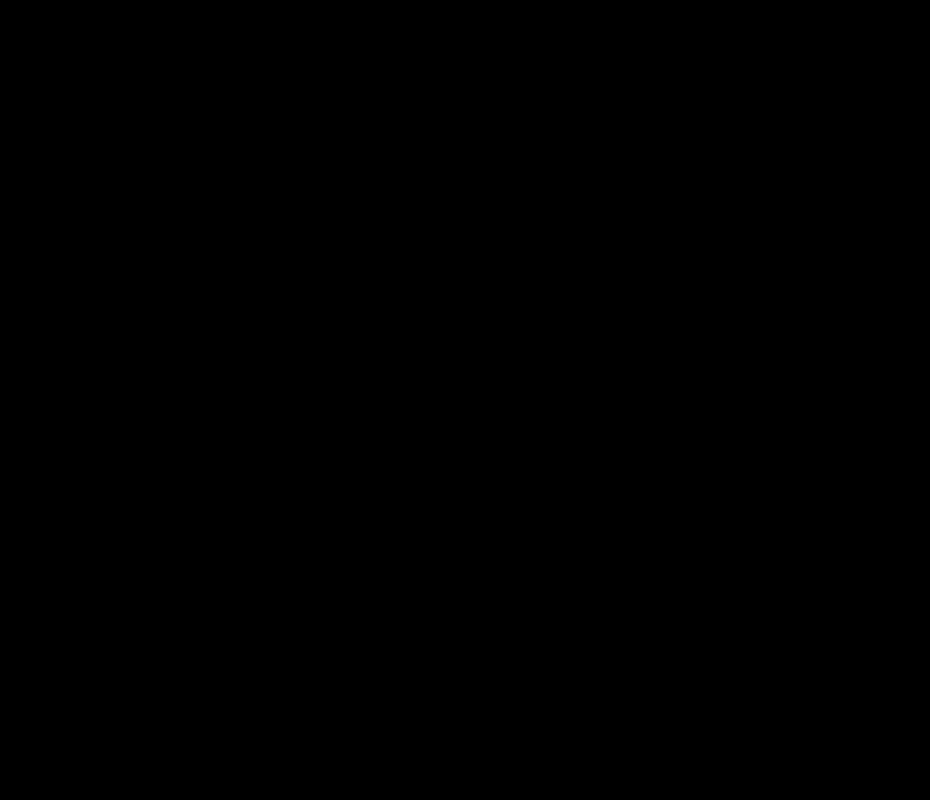
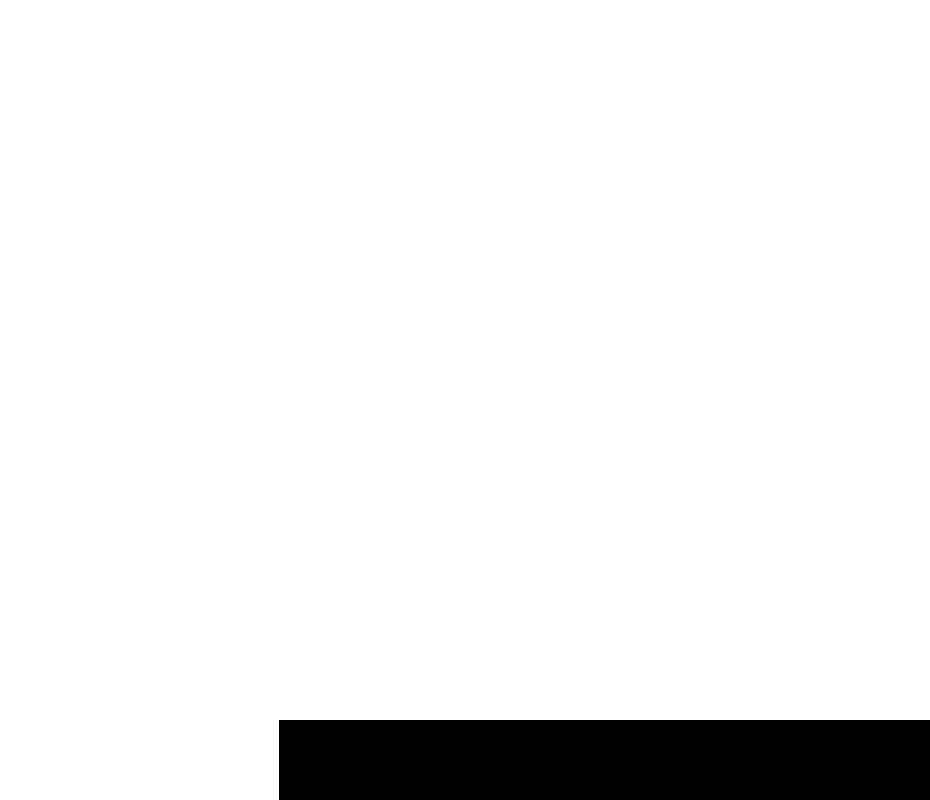

In [17]:

idx = 0
nip.view_img(
    nib.Nifti1Image(predictions[0][0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)


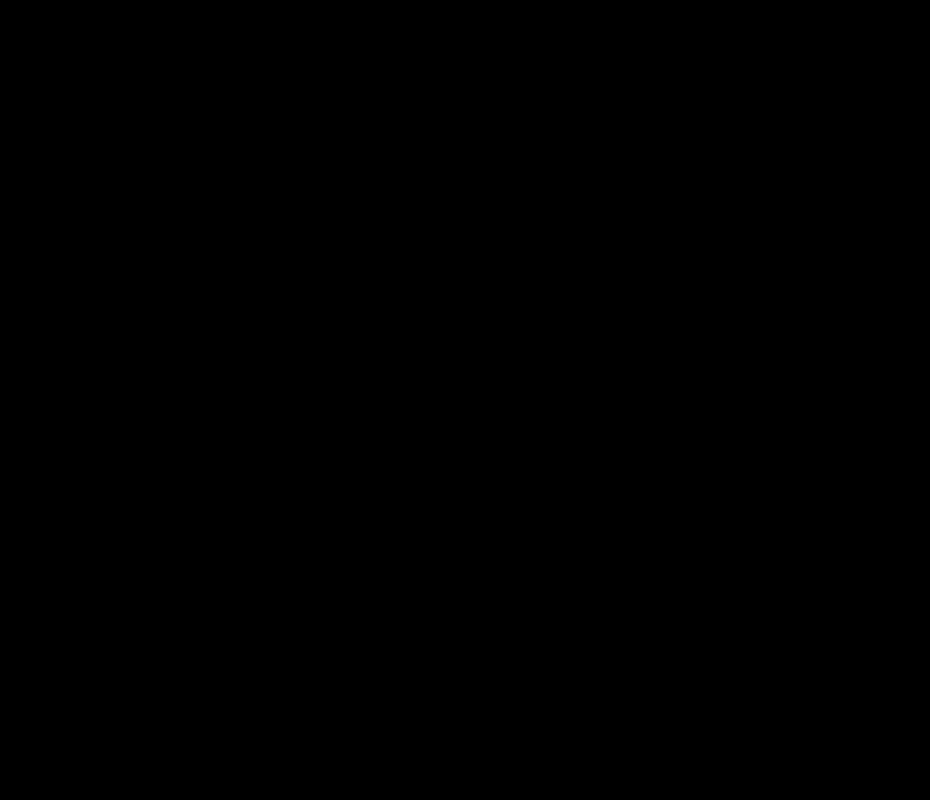
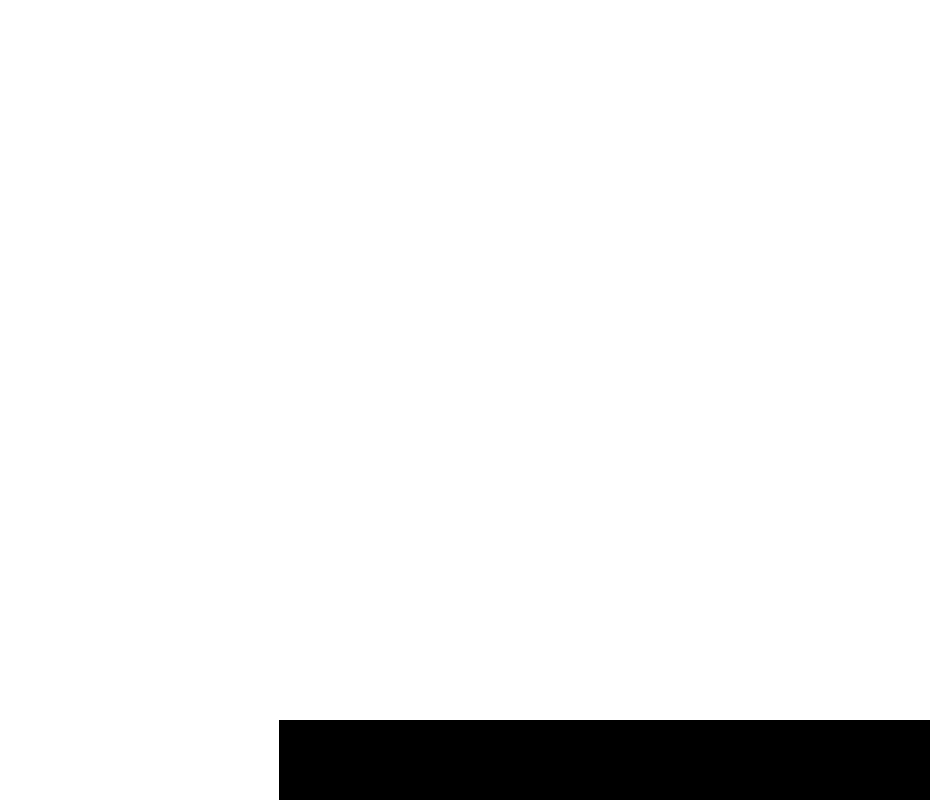

In [18]:
idx = 0
nip.view_img(
    nib.Nifti1Image(labels_val[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)